## Module 17: Learning Notebook: Metrics ROC and AUC

The AUC-ROC curve helps us visualize how well our machine learning classifier is performing. It's a better metric than accuracy. We'll discuss why below.

Reference: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import boto3
import pandas as pd
import numpy as np

### 1. Load and Prepare Cancer Data

In [2]:
# Load from S3
sess = boto3.session.Session()
s3 = sess.client('s3') 
source_bucket = 'machinelearning-read-only'
source_key = 'data/cancer-10.csv' 
response = s3.get_object(Bucket = source_bucket, Key = source_key)
df = pd.read_csv(response.get("Body"))
# Prepare data
X = df.drop(['cancer_detected'], axis = 1)
y = df['cancer_detected']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state = 7)

### 2. Model using Logistic Regression

In [3]:
# Logitic Regression
scaler = StandardScaler() # Standardize the data
lr = LogisticRegression()
steps = [('Scaler', scaler), ('LogReg', lr)]
lr_pipe = Pipeline(steps)
lr_pipe.fit(X_train, y_train)
lr_y_pred = lr_pipe.predict(X_test)
lr_acc = accuracy_score(y_test, lr_y_pred)
print('Logistic Regression accuracy:', round(lr_acc,4))
print('Confusion Matrix: \n', confusion_matrix(y_test, lr_y_pred,labels = [1,0]))
# Store each value in the matrix. We'll use them below
lr_tp, lr_fp, lr_fn, lr_tn = confusion_matrix(y_test, lr_y_pred,labels = [1,0]).ravel()
# Print them out and disucss
lr_tp, lr_fp, lr_fn, lr_tn

Logistic Regression accuracy: 0.905
Confusion Matrix: 
 [[  1  17]
 [  2 180]]


(1, 17, 2, 180)

### 3. More "intermediate" performance definitions: FPR and TRP
Below, we will plot FPR vs TPR. Let'ss see how those are calculated.

In [4]:
# False Positive Rate
# FPR tells us what proportion of the negative class got incorrectly classified by the classifier.
fpr = lr_fp / (lr_tn + lr_fp)
round(fpr,3)

0.086

In [5]:
# Calculate True Positive Rate, tpr
# We've already seen this as "recall", also known as Sensitivity. I'm not sure why there are so many names for it.
# TPR tells us what proportion of the positive class got correctly classified.
tpr = lr_tp / (lr_tp + lr_fn)
round(tpr,3)

0.333

### 4. Predict probability of being False (0) or True (1) instead of merely predicting integers
Almost always, classification algorithms allow you to predict the probability of being in a class. For example, the logistic regression algorithm has the function:<P>
    
**predict_prob()** - this returns the probability of a rows being both 0 and 1

In [6]:
# predict probability of being in each class
# Original Prediction of Integer for rows 15:20
print('\nOriginal Logistic Regression Model Predction for rows 15 - 20:', lr_y_pred[15:20])
#
# Now generate probabilities of being 0 or 1
lr_y_pred_prob = lr_pipe.predict_proba(X_test)
#
# Show rows 15 - 20 from the predicted data
# P(0) and P(1)
print('Probability of being in False (0) or True (1) Class for rows 15-20:\n', lr_y_pred_prob[15:20])
#
# Notice our current "threshold" is 0.5


Original Logistic Regression Model Predction for rows 15 - 20: [0 1 0 0 0]
Probability of being in False (0) or True (1) Class for rows 15-20:
 [[0.66007584 0.33992416]
 [0.3292678  0.6707322 ]
 [0.79674984 0.20325016]
 [0.93003456 0.06996544]
 [0.95676617 0.04323383]]


### 5. ROC - Receiver Operator Characteristic Curve
The ROC curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at **various threshold** values.

Ideally, we want TPR to be maximized and FPR to be minimized. Think of these as points along a line in a graph.

Area Under the Curve (AUC)  is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

When AUC = 1, then the classifier is able to perfectly distinguish between all the Positive and the Negative class points correctly. This is too good to be true.<BR>
<img src="images/auc1.png" width=150 height=150 /><BR>
    
When 0.5 < AUC < 1, there is a high chance that the classifier will be able to distinguish the positive class values from the negative class values. This is desirable.<BR>
<img src="images/auc2.png" width=150 height=150 /><BR>

When AUC=0.5 or less, then the classifier is not able to distinguish between Positive and Negative class points. Kind of like flipping a coin.<BR>

<img src="images/auc3.png" width=150 height=150 /><BR>

So, the higher the AUC value for a classifier, the better its ability to distinguish between positive and negative classes. High AUC is good. 

### 6. Model a competing algorithm
So we can compare, let's use a different algorithm: Gradient Boosting Classifier

In [7]:
# Model usign GBC
scaler = StandardScaler() # Standardize the data
gbc = GradientBoostingClassifier()
steps = [('Scaler', scaler), ('GBC', gbc)]
gbc_pipe = Pipeline(steps)
gbc_pipe.fit(X_train, y_train)
gbc_y_pred = gbc_pipe.predict(X_test)
gbc_acc = accuracy_score(y_test, gbc_y_pred)
print('Gradient Boosting Classifier accuracy:', round(gbc_acc,4))
print('Confusion Matrix: \n', confusion_matrix(y_test, gbc_y_pred,labels = [1,0]))
# Store each value in the matrix
# gbc_tp, gbc_fp, gbc_fn, gbc_tn = confusion_matrix(y_test, gbc_y_pred,labels = [1,0]).ravel()
# # Calculate TPR and FPR
# gbc_tpr = gbc_tp / (gbc_tp + gbc_fn)
# gbc_fpr = gbc_fp / (gbc_tn + gbc_fp)
# predict probability of being in each class
gbc_y_pred_prob = gbc_pipe.predict_proba(X_test)

Gradient Boosting Classifier accuracy: 0.915
Confusion Matrix: 
 [[  5  13]
 [  4 178]]


### 7. What is the Area Under the Curve (AUC) score for the existing algorithms?

In [8]:
# Before we generate curves, let's just compute AUC
from sklearn.metrics import roc_auc_score

# auc scores
lr_auc_score = roc_auc_score(y_test, lr_y_pred_prob[:,1])
gbc_auc_score = roc_auc_score(y_test, gbc_y_pred_prob[:,1])

print('Current Logistic Regression AUC Score:', round(lr_auc_score,3))
print('Current GBC AUC Score:', round(gbc_auc_score,3))

Current Logistic Regression AUC Score: 0.705
Current GBC AUC Score: 0.909


### 8. Generate ROC Curves to Compare Algorithms

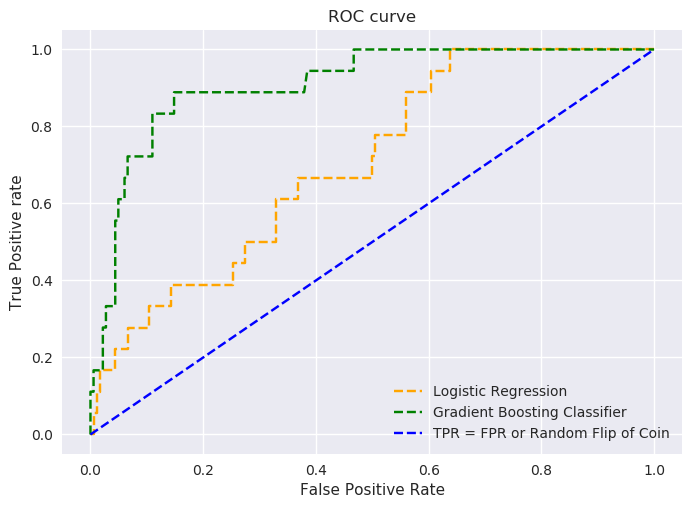

In [9]:
# This is the code to generate the datapoints for a curve
#  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
from sklearn.metrics import roc_curve
#
# Generate points for ROC curves for models
lr_fpr, lr_tpr, lr_thresh = roc_curve(y_test, lr_y_pred_prob[:,1], pos_label=1) # y_test & P(1)
gbc_fpr, gbc_tpr, gbc_thresh = roc_curve(y_test, gbc_y_pred_prob[:,1], pos_label=1)
#
# roc curve for tpr = fpr (Straight line, like flipping a coin)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
#
# Code to plot those points
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
# plot roc curves
plt.plot(lr_fpr, lr_tpr, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(gbc_fpr, gbc_tpr, linestyle='--',color='green', label='Gradient Boosting Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label='TPR = FPR or Random Flip of Coin')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

### 9. What if we use a different threshold than 0.5?

In this case, we are using a dataset with a big imbalance many more False than True

In [10]:
# Whole dataset
df['cancer_detected'].value_counts()

0    899
1    101
Name: cancer_detected, dtype: int64

In [11]:
# Test dataset
y_test.value_counts()

0    182
1     18
Name: cancer_detected, dtype: int64

For those classification problems that have a severe class imbalance, the default threshold can result in poor performance. As such, a simple and straightforward approach to improving the performance of a classifier that predicts probabilities on an imbalanced classification problem is to tune the threshold used to map probabilities to class labels.

In [12]:
# Recall our confusion matrix using a threshold of 0.5, the default for Logistic Regression
confusion_matrix(y_test, lr_y_pred,labels = [1,0])

array([[  1,  17],
       [  2, 180]])

In [13]:
# Let's iterate over the theshold values of .1 to .95 and evalute how the predictions to for each threshold
for i in np.arange(.05, .95, 0.05):
    thresh = i # Set the threshold
    temp_pred = (gbc_pipe.predict_proba(X_test)[:,1] >= thresh).astype(int) # This accepts as True if over threshold
    # Now print the confusion matrix
    # Remember, for cancer detection, we really want to avoid not identifying cancer
    print('Confusion Matrix for threshold = :', round(thresh,2),' \n', confusion_matrix(y_test, temp_pred,labels = [1,0]),'\n')

Confusion Matrix for threshold = : 0.05  
 [[ 16   2]
 [ 33 149]] 

Confusion Matrix for threshold = : 0.1  
 [[ 15   3]
 [ 20 162]] 

Confusion Matrix for threshold = : 0.15  
 [[ 13   5]
 [ 15 167]] 

Confusion Matrix for threshold = : 0.2  
 [[ 12   6]
 [ 11 171]] 

Confusion Matrix for threshold = : 0.25  
 [[  9   9]
 [  8 174]] 

Confusion Matrix for threshold = : 0.3  
 [[  7  11]
 [  8 174]] 

Confusion Matrix for threshold = : 0.35  
 [[  6  12]
 [  7 175]] 

Confusion Matrix for threshold = : 0.4  
 [[  6  12]
 [  5 177]] 

Confusion Matrix for threshold = : 0.45  
 [[  6  12]
 [  5 177]] 

Confusion Matrix for threshold = : 0.5  
 [[  5  13]
 [  4 178]] 

Confusion Matrix for threshold = : 0.55  
 [[  5  13]
 [  4 178]] 

Confusion Matrix for threshold = : 0.6  
 [[  4  14]
 [  4 178]] 

Confusion Matrix for threshold = : 0.65  
 [[  4  14]
 [  4 178]] 

Confusion Matrix for threshold = : 0.7  
 [[  3  15]
 [  3 179]] 

Confusion Matrix for threshold = : 0.75  
 [[  2  16]
 

There is much more to discuss here, but we'll stop.